In [30]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import pydotplus
import graphviz
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
from sklearn import tree
from IPython.display import Image
from sqlalchemy import create_engine
%matplotlib inline

import warnings
warnings.filterwarnings(action="ignore")

In [31]:
# Here is the medical costs dataset from previous modules

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'medicalcosts'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

df = pd.read_sql_query('select * from medicalcosts',con=engine)

engine.dispose()


df.head(20)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.90
1,18,male,33.770,1,no,southeast,1725.55
2,28,male,33.000,3,no,southeast,4449.46
3,33,male,22.705,0,no,northwest,21984.50
4,32,male,28.880,0,no,northwest,3866.86
5,31,female,25.740,0,no,southeast,3756.62
6,46,female,33.440,1,no,southeast,8240.59
7,37,female,27.740,3,no,northwest,7281.51
8,37,male,29.830,2,no,northeast,6406.41
9,60,female,25.840,0,no,northwest,28923.10


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
age         1338 non-null int64
sex         1338 non-null object
bmi         1338 non-null float64
children    1338 non-null int64
smoker      1338 non-null object
region      1338 non-null object
charges     1338 non-null float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [34]:
df = pd.get_dummies(df, columns = ['sex','region','smoker'], drop_first=True)
df

,age,bmi,children,charges,sex_male,region_northwest,region_southeast,region_southwest,smoker_yes
0,19,27.900,0,16884.90,0,0,0,1,1
1,18,33.770,1,1725.55,1,0,1,0,0
2,28,33.000,3,4449.46,1,0,1,0,0
3,33,22.705,0,21984.50,1,1,0,0,0
4,32,28.880,0,3866.86,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...
1333,50,30.970,3,10600.50,1,1,0,0,0
1334,18,31.920,0,2205.98,0,0,0,0,0
1335,18,36.850,0,1629.83,0,0,1,0,0
1336,21,25.800,0,2007.94,0,0,0,1,0


In [36]:
#df['smoker_yes'] = df['smoker_yes'].astype(np.int64)
df = df.round(0).astype(int)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 9 columns):
age                 1338 non-null int32
bmi                 1338 non-null int32
children            1338 non-null int32
charges             1338 non-null int32
sex_male            1338 non-null int32
region_northwest    1338 non-null int32
region_southeast    1338 non-null int32
region_southwest    1338 non-null int32
smoker_yes          1338 non-null int32
dtypes: int32(9)
memory usage: 47.2 KB


In [57]:
# This time we predict if an individual is a smoker (using decision tree and random forest classifiers)

X = df.drop(columns = 'smoker_yes', axis=1)
Y = df['smoker_yes']
X

,age,bmi,children,charges,sex_male,region_northwest,region_southeast,region_southwest
0,19,28,0,16885,0,0,0,1
1,18,34,1,1726,1,0,1,0
2,28,33,3,4449,1,0,1,0
3,33,23,0,21984,1,1,0,0
4,32,29,0,3867,1,1,0,0
...,...,...,...,...,...,...,...,...
1333,50,31,3,10600,1,1,0,0
1334,18,32,0,2206,0,0,0,0
1335,18,37,0,1630,0,0,1,0
1336,21,26,0,2008,0,0,0,1


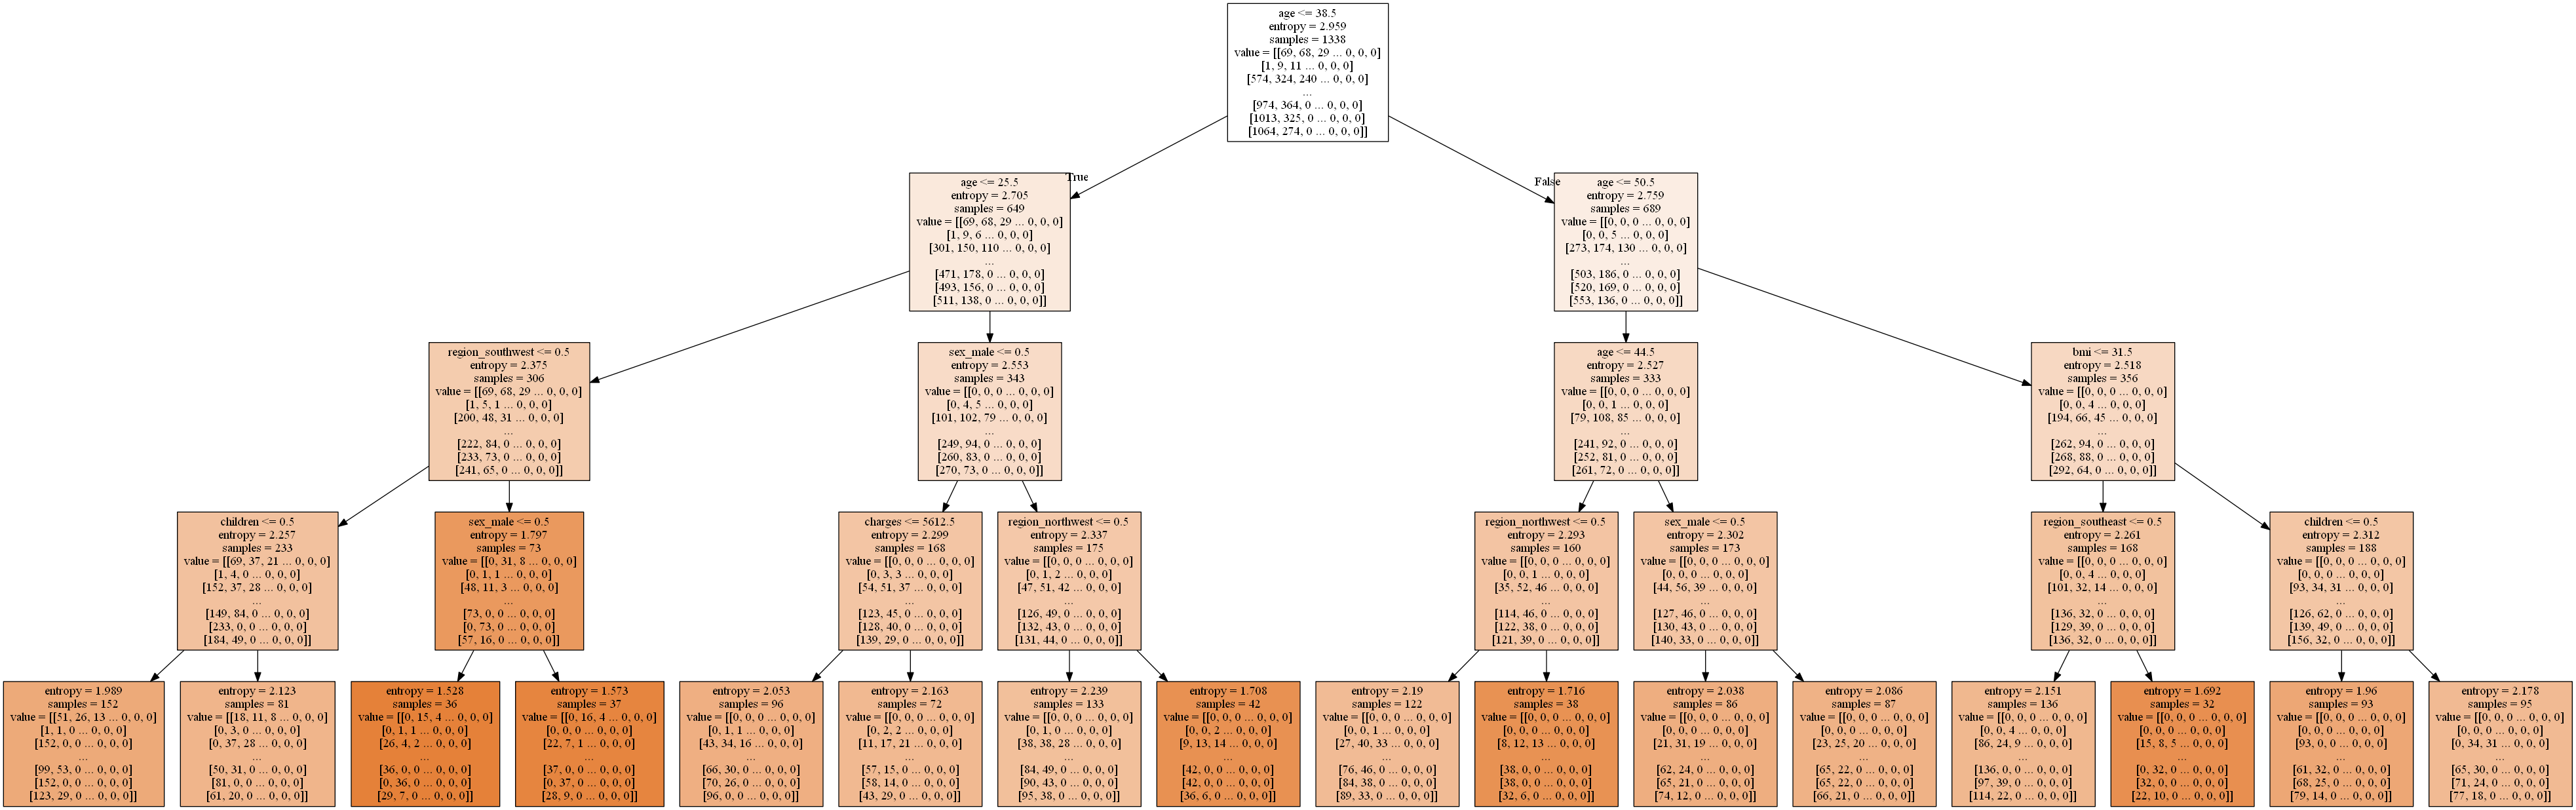

In [82]:
# Initialize and train our tree.

import os
os.environ['PATH'] = os.environ['PATH']+';'+os.environ['CONDA_PREFIX']+r"\Library\bin\graphviz"


decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=1,
    max_depth=4,
    
)
decision_tree.fit(X, df)

dot_data = tree.export_graphviz(
    decision_tree, out_file=None,
    feature_names=X.columns,
    class_names=['Not Smoker', 'Smoker'],
    filled=True
)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [91]:
score1 = cross_val_score(decision_tree, X, Y, cv=10)
print(score1)
print("Accuracy: %0.2f (+/- %0.2f)" % (score1.mean(), score1.std() * 2))

[0.86666667 0.80740741 0.85925926 0.79259259 0.89473684 0.92481203
 0.85714286 0.88721805 0.81954887 0.94736842]
Accuracy: 0.87 (+/- 0.09)


In [93]:
rfc = ensemble.RandomForestClassifier()

score2 = cross_val_score(rfc, X, Y, cv=10)
print(score2)
print("Accuracy: %0.2f (+/- %0.2f)" % (score2.mean(), score2.std() * 2))

[0.93333333 0.94074074 0.94074074 0.93333333 0.96240602 0.97744361
 0.96240602 0.93984962 0.96992481 0.96992481]
Accuracy: 0.95 (+/- 0.03)


The runtime of the random forest classifier was nearly instant, since this dataset is relatively small. In this case, there is little reason to prefer to decision tree.